In [1]:
import scanpy as sc
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import median_abs_deviation as mad
import numpy as np
import anndata as adt
from scipy.sparse import csr_matrix
import umap
import scanpy.external as sce

In [2]:
import warnings 
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# Concatenation & UMAP

In [36]:
adatas_red = []
data_dir = 'C:/Users/MDV/Documents/Pipeline folder Yohan/scP/Output/Formated_data'

for filename in os.listdir(data_dir):
    if filename.endswith('.h5ad'):
            adata = sc.read_h5ad(os.path.join(data_dir, filename))
            adata.var_names_make_unique()
            adatas_red.append(adata)

print(f"Nombre de fichiers h5ad chargés avec succès : {len(adatas_red)}")

Nombre de fichiers h5ad chargés avec succès : 6


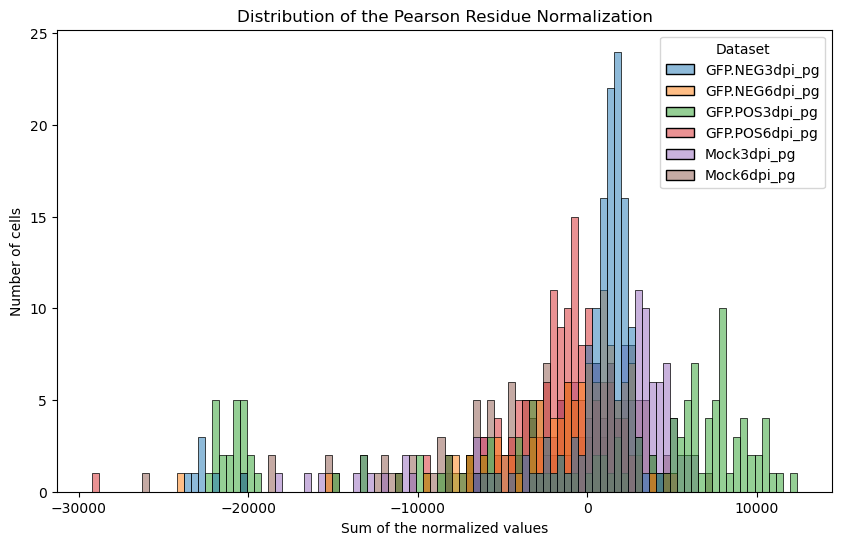

In [37]:
plot_data = []

for ade in adatas_red:
    ad = ade.copy()
    ad.X = np.nan_to_num(ad.X, nan=0.0)  
    analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(ad, inplace=False)
    
    X_fixed = analytic_pearson["X"]
    
    plot_data.extend([(x, ad.obs['Id'][0]) for x in csr_matrix(X_fixed).sum(1).A1])

df_plot = pd.DataFrame(plot_data, columns=["Normalized Sum", "Dataset"])

plt.figure(figsize=(10, 6))
ax = sns.histplot(data=df_plot, x="Normalized Sum", hue="Dataset", bins=100, kde=False, palette="tab10")

plt.xlabel("Sum of the normalized values")
plt.ylabel("Number of cells")
plt.title("Distribution of the Pearson Residue Normalization")

# Afficher le plot
plt.show()

In [38]:
adata1 = adt.concat(adatas_red, join="outer", index_unique="-", merge="unique")
adata1.layers['raw'] = adata1.X
adata1.X = np.nan_to_num(adata1.X, nan=0.0)

In [39]:
adata1.obs["sample"] = ["Mock" if "Mock" in str(x) else "Inf" for x in adata1.obs["Id"]]
adata_mock = adata1[adata1.obs["sample"] == "Mock"]

In [40]:
analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata_mock, inplace=False)
X_fixed = analytic_pearson["X"]
X_fixed[np.isnan(X_fixed)] = 0 
adata_mock.layers["analytic_pearson_residuals_train"] = csr_matrix(X_fixed)
adata_mock.X = adata_mock.layers["analytic_pearson_residuals_train"]
sc.pp.pca(adata_mock)
sce.pp.scanorama_integrate(adata_mock, 'Id', verbose =1)

Processing datasets Mock3dpi_pg <=> Mock6dpi_pg


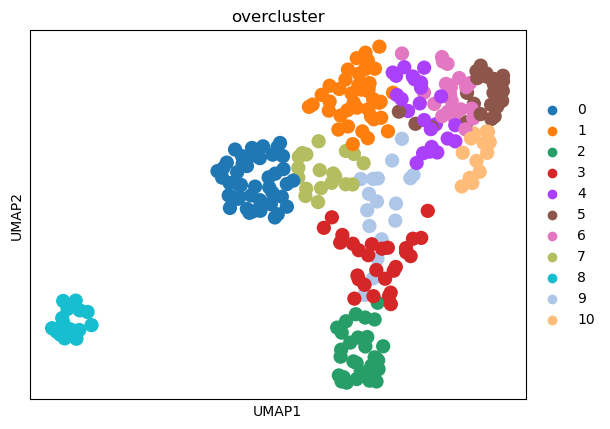

In [41]:
sc.pp.neighbors(adata_mock, use_rep = 'X_scanorama')
sc.tl.leiden(adata_mock, resolution = 2, key_added = 'overcluster')
sc.tl.umap(adata_mock)
sc.pl.umap(
    adata_mock,
    color=['overcluster']
)

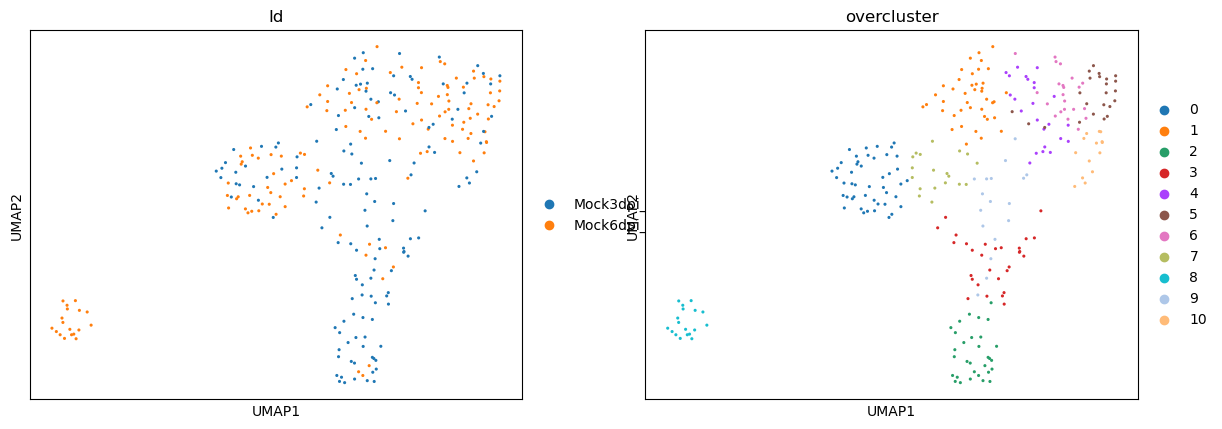

In [44]:
np.random.seed(1)
ri = np.random.permutation(list(range(adata_mock.shape[0])))

sc.pl.umap(adata_mock[ri,:], color = ['Id','overcluster'], vmin = .5, size = 20)

In [45]:
sc.tl.rank_genes_groups(adata_mock, groupby = 'overcluster')
marks = sc.get.rank_genes_groups_df(adata_mock, group = None)

In [46]:
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd

In [47]:
def ranking_evaluation_cluster(marks_cluster, size_rk):
    selected_genes = marks_cluster['names'][:size_rk]
    if marks_cluster.loc[marks_cluster['names'].isin(selected_genes), 'logfoldchanges'].isna().any():
        raise ValueError("Error; NaN values found in the selected proteins")

    ranking_id = marks_cluster['group'].unique()[0]
    rankings_cluster = {f"{ranking_id}": {prot: i + 1 for i, prot in enumerate(selected_genes)}}
    return rankings_cluster

In [48]:
def ranking_evaluation(marks, size_rk):
    # do not allow NaN values
    ranking = {}
    for num in marks['group'].unique():
        marks_cluster = marks[(marks.group == f"{num}") ].sort_values('logfoldchanges', ascending = False)
        rankings_cluster = ranking_evaluation_cluster(marks_cluster, size_rk)
        ranking.update(rankings_cluster)
    return ranking

In [49]:
def common(ranking):
    all_genes = list(set.union(*[set(list(ranking[cluster].keys())) for cluster in list(ranking.keys())]))

    presence_matrix = pd.DataFrame(0, index=all_genes, columns=[f"Dataset {cluster}" for cluster in list(ranking.keys())])

    for cluster in list(ranking.keys()):
        presence_matrix.loc[list(ranking[cluster].keys()), f"Dataset {cluster}"] = 1

    compte = pd.DataFrame(0, index=all_genes, columns=[f"Seen in {i+1} clusters" for i in range(len(list(ranking.keys())))])
    sum_presencematrix = presence_matrix.sum(1)
    for gene in all_genes:
        presence_count = sum_presencematrix[gene] 
        compte.loc[gene, f"Seen in {presence_count} clusters"] = 1  


    column_sums = compte.sum(axis=0)


    plt.figure(figsize=(8, 6))
    sns.barplot(x=column_sums.index, y=column_sums.values, palette="viridis")

    plt.xlabel("Number of datasets where proteins seen")
    plt.ylabel("Number of proteins")
    plt.title("Number of proteins shared between datasets")


    plt.xticks(rotation=45)

    plt.show()

In [50]:
def custom_dendrogram(*args, **kwargs):
    dendro_data = sch.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for icoord, dcoord in zip(dendro_data['icoord'], dendro_data['dcoord']):
            x_coord = 0.5 * sum(icoord[1:3])  
            height = dcoord[1]  
            plt.plot(x_coord, height, 'ro') 
            plt.annotate(f"{height:.3g}", (x_coord, height), xytext=(0, -8),
                         textcoords='offset points', va='top', ha='center')  

    return dendro_data

In [51]:
def evolution_number_cluster(linkage_matrix):
    distances = linkage_matrix[:, 2]  
    max_distance = max(distances)
    cluster_counts = []

    for distance in distances:
        clusters = sch.fcluster(linkage_matrix, t=distance, criterion='distance')
        cluster_counts.append(len(np.unique(clusters)))

# print of the figure
    plt.figure(figsize=(8, 6))
    plt.plot(distances, cluster_counts, marker='o')
    plt.xlabel('Distance')
    plt.ylabel('Number of clusters')
    plt.title('Evolution of the number of cluster')
    plt.grid(True)
    plt.show()


In [52]:
def evolution_metacluster(linkage_matrix,list_cluster):

    distances = np.concatenate(([0], linkage_matrix[:, 2]))
    cluster_counts = []
    single_elements_counts = []

    n_elements = len(list_cluster)
    for distance in distances:
        clusters = np.concatenate(([0],sch.fcluster(linkage_matrix, t=distance, criterion='distance')))
        cluster_sizes = np.bincount(clusters)
    
        valid_clusters = np.sum(cluster_sizes >= 2)
        cluster_counts.append(valid_clusters)
    
        single_elements = np.sum(cluster_sizes == 1)
        single_elements_counts.append(single_elements)

    plt.figure(figsize=(8, 6))
    plt.plot(distances,cluster_counts, marker='o', label='MetaCluster')
    plt.xlabel('Distance')
    plt.ylabel('Number of MetaCluster')
    plt.title('Evolution of the number of MetaCluster')
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(distances, single_elements_counts, marker='x', color='green', label='Number of clusters out of MetaCluster')
    plt.xlabel('Distance')
    plt.ylabel('Number of clusters out of MetaCluster')
    plt.title('Evolution of the Number of clusters out of MetaCluster depending of the distance')
    plt.grid(True)
    plt.legend()
    plt.show()

In [53]:
def ranking_dendrogramme(marks, size_rk):
    ranking = ranking_evaluation(marks, size_rk)
    common(ranking)

    all_genes = list(set.union(*[set(list(ranking[cluster].keys())) for cluster in list(ranking.keys())]))
    data = {}
    list_cluster = []
    for cluster_id, proteins in ranking.items():
        list_cluster.append(cluster_id)
        row = {gene: np.nan for gene in all_genes}
        for protein, rank in proteins.items():
            row[protein] = rank
        data[cluster_id] = row

    df_ranking = pd.DataFrame(data).T
    df_ranking.fillna(df_ranking.max().max()+1,inplace=True)
    dist_matrix = ssd.squareform(ssd.pdist(df_ranking, metric="correlation"))
    linkage_matrix = sch.linkage(dist_matrix, method="ward")

    evolution_number_cluster(linkage_matrix)
    evolution_metacluster(linkage_matrix,list_cluster)
    
    plt.figure(figsize=(10, 5))
    plt.figure(figsize=(10, 4))
    dendro_data = custom_dendrogram(linkage_matrix)
    plt.title("Dendrogramm of the clusters")
    plt.xlabel("Clusters")
    plt.ylabel("Distance")
    plt.show()

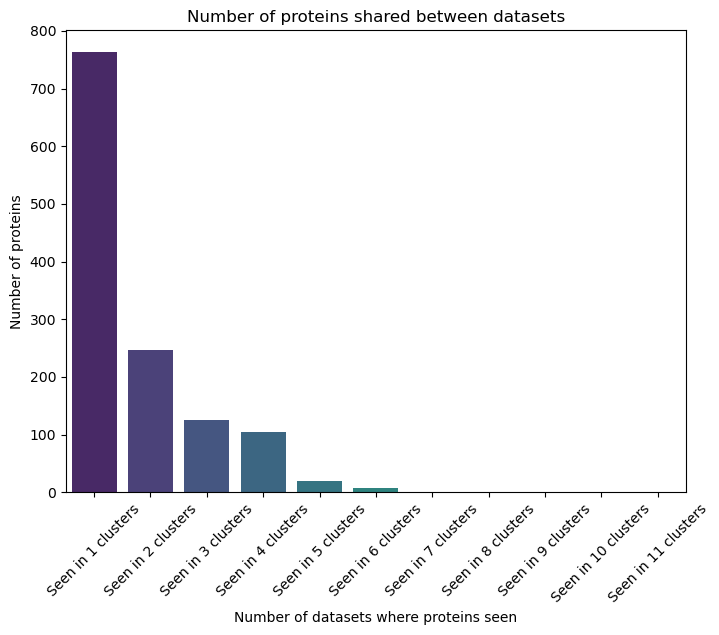

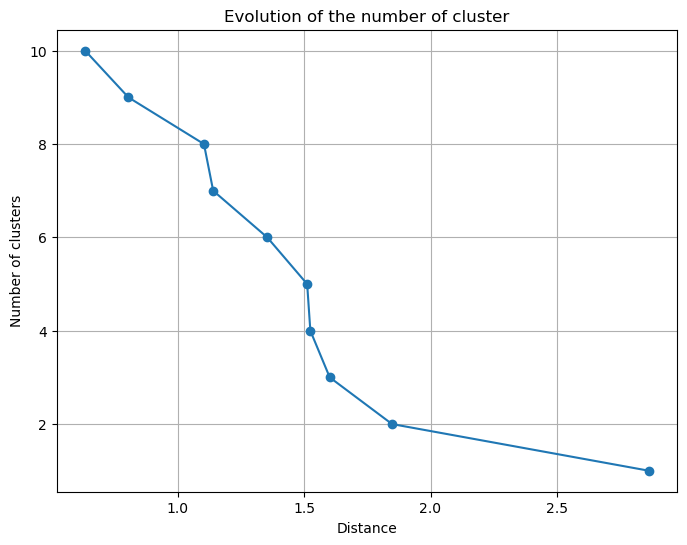

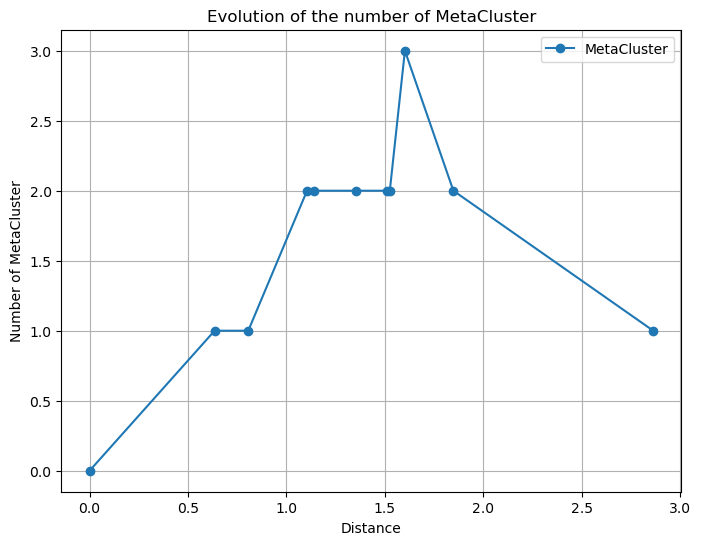

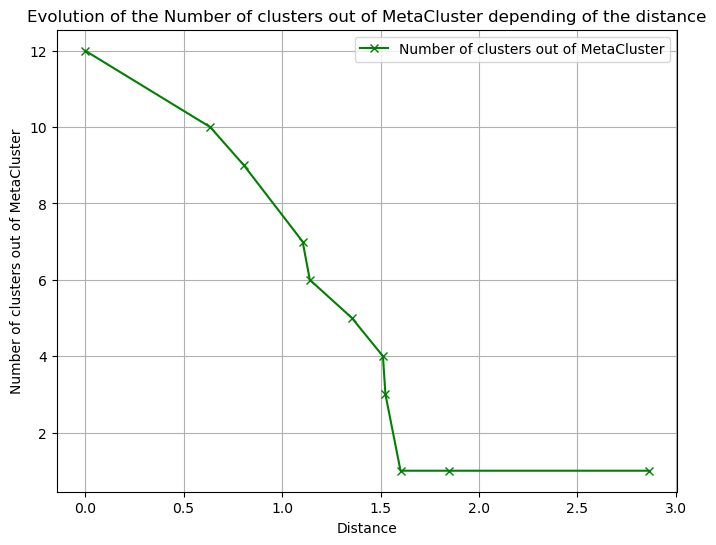

<Figure size 1000x500 with 0 Axes>

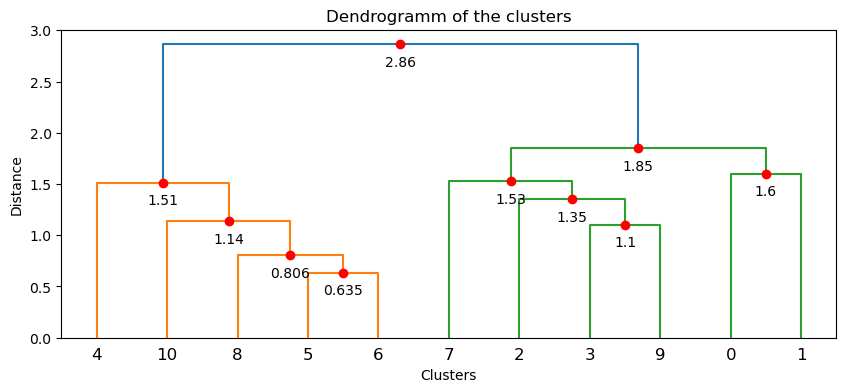

In [107]:
ranking_dendrogramme(marks, 200)

In [112]:
marks[(marks.group == '7') ].sort_values('logfoldchanges', ascending = False).head(60)

,group,names,scores,logfoldchanges,pvals,pvals_adj
28772,7,HSDL2_HUMAN,-1.007461,11.662716,0.322855,0.642646
28368,7,ZRAB2_HUMAN,-0.342246,10.964416,0.735624,1.000000
26537,7,EHD1_HUMAN,2.370086,10.863380,0.027755,0.118598
26610,7,FLNA_HUMAN,1.854130,10.199255,0.079738,0.256426
29603,7,TMED7_HUMAN,-2.749944,10.152752,0.010916,0.061244
26504,7,WASF2_HUMAN,2.649098,9.970584,0.013430,0.070824
28950,7,RAB35_HUMAN,-1.302000,9.500898,0.206189,0.485997
26568,7,JUPI1_HUMAN,2.177640,8.926138,0.041675,0.160412
29902,7,MYH14_HUMAN,-3.788106,8.902327,0.000965,0.010656
27083,7,TCPW_HUMAN,0.645325,8.471117,0.525557,0.853134


In [93]:
def common_prot_clusters(marks, size_rk,cluster_group,ranking):
    common_prot = list(set.intersection(*[set(list(ranking[cluster].keys())) for cluster in cluster_group]))
    return common_prot

In [97]:
def common_prot_clusters_mssv(marks, size_rk, cluster_group, ranking):
    miss_value = 1
    all_proteins = set.union(*[set(ranking[cluster].keys()) for cluster in cluster_group])
    prot_count = {prot: sum(prot in ranking[cluster] for cluster in cluster_group) for prot in all_proteins}
    common_prot = [prot for prot, count in prot_count.items() if count >= len(cluster_group) - miss_value]
    return common_prot

In [98]:
def tab_sim_prot(marks, size_rk,cluster_group):
    ranking = ranking_evaluation(marks, size_rk)
    common_prot = common_prot_clusters(marks, size_rk,cluster_group,ranking)
    print(common_prot)
    data = {}
    
    for cluster_id, proteins in ranking.items():
        if cluster_id in cluster_group:
            row = {prot: np.nan for prot in common_prot}
            for protein, rank in proteins.items():
                if protein in common_prot:
                    row[protein] = rank
            data[cluster_id] = row
    
    df_ranking = pd.DataFrame(data).T
    df_ranking.fillna(df_ranking.max().max()+1,inplace=True)
    return df_ranking

In [96]:
def tab_sim_prot_mssv(marks, size_rk,cluster_group):
    ranking = ranking_evaluation(marks, size_rk)
    common_prot = common_prot_clusters_mssv(marks, size_rk,cluster_group,ranking)
    print(common_prot)
    data = {}
    
    for cluster_id, proteins in ranking.items():
        if cluster_id in cluster_group:
            row = {prot: np.nan for prot in common_prot}
            for protein, rank in proteins.items():
                if protein in common_prot:
                    row[protein] = rank
            data[cluster_id] = row
    
    df_ranking = pd.DataFrame(data).T
    df_ranking.fillna(df_ranking.max().max()+1,inplace=True)
    return df_ranking

In [108]:
cluster_group1 = ['10', '4','8','5','6']

In [80]:
cluster_group2 = ['7', '2', '3','9']

In [81]:
cluster_group3 = ['1', '0']

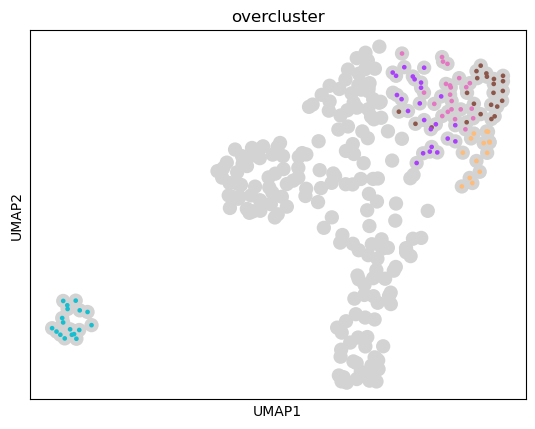

In [82]:
ax = sc.pl.umap(adata_mock, palette = 'lightgrey', show = False)
adata_clusters = adata_mock[adata_mock.obs['overcluster'].isin(cluster_group1)]

sc.pl.umap(adata_clusters, 
           color='overcluster',  
           size=45,              
           ax=ax,               
           legend_loc=None     
          )  

plt.show()

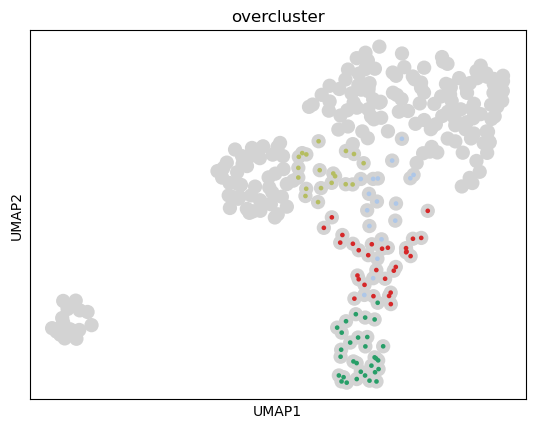

In [83]:
ax = sc.pl.umap(adata_mock, palette = 'lightgrey', show = False)
adata_clusters = adata_mock[adata_mock.obs['overcluster'].isin(cluster_group2)]

sc.pl.umap(adata_clusters, 
           color='overcluster',  
           size=45,              
           ax=ax,               
           legend_loc=None     
          )  

plt.show()

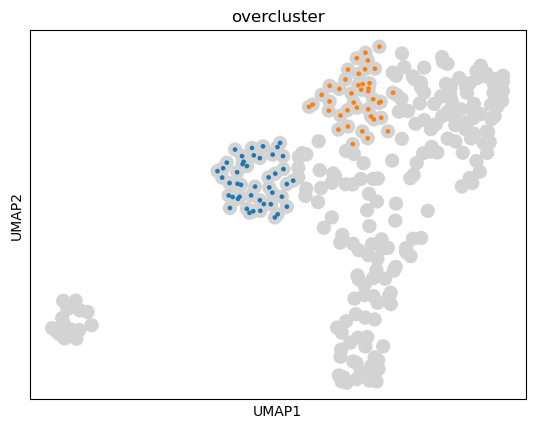

In [84]:
ax = sc.pl.umap(adata_mock, palette = 'lightgrey', show = False)
adata_clusters = adata_mock[adata_mock.obs['overcluster'].isin(cluster_group3)]

sc.pl.umap(adata_clusters, 
           color='overcluster',  
           size=45,              
           ax=ax,               
           legend_loc=None     
          )  

plt.show()

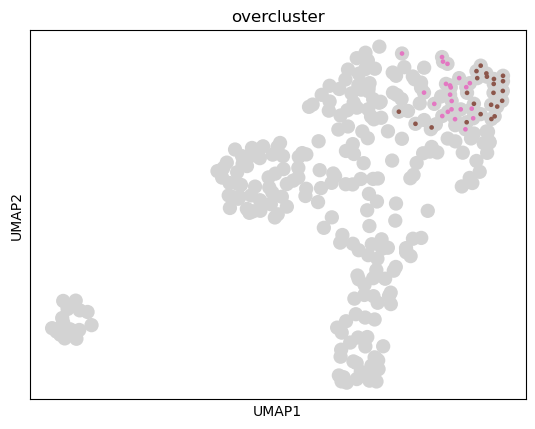

In [109]:
ax = sc.pl.umap(adata_mock, palette = 'lightgrey', show = False)
adata_clusters = adata_mock[adata_mock.obs['overcluster'].isin(['5','6'])]

sc.pl.umap(adata_clusters, 
           color='overcluster',  
           size=45,              
           ax=ax,               
           legend_loc=None     
          )  

plt.show()

In [99]:
tab_sim_prot_mssv(marks, 200,cluster_group1)

['KCC2G_HUMAN', 'RSSA_HUMAN', 'UBQL2_HUMAN', 'ASCC2_HUMAN', 'NFIB_HUMAN', 'BCCIP_HUMAN', 'SCAF8_HUMAN', 'WASH2_HUMANWASH3_HUMAN', 'HID1_HUMAN', 'GSK3B_HUMAN', 'IMA5_HUMAN', 'SCYL1_HUMAN', 'DLRB2_HUMAN', 'OSCP1_HUMAN', 'TSNAX_HUMAN', 'ERI3_HUMAN', 'VATF_HUMAN', 'VAV_HUMAN', 'SYYC_HUMAN', 'REPS1_HUMAN', 'S10A4_HUMAN', 'NFYC_HUMAN', 'OXR1_HUMAN', 'MMS19_HUMAN', 'DNJA4_HUMAN', 'PIN4_HUMAN', 'RAMAC_HUMAN', 'TBAL3_HUMAN', 'RUFY1_HUMAN', 'TBC23_HUMAN', 'GLP3L_HUMAN', 'PARVA_HUMAN', 'PCY1A_HUMAN', 'COMD2_HUMAN', 'PPM1H_HUMAN', 'Keratin-12']


,KCC2G_HUMAN,RSSA_HUMAN,UBQL2_HUMAN,ASCC2_HUMAN,NFIB_HUMAN,BCCIP_HUMAN,SCAF8_HUMAN,WASH2_HUMANWASH3_HUMAN,HID1_HUMAN,GSK3B_HUMAN,...,RAMAC_HUMAN,TBAL3_HUMAN,RUFY1_HUMAN,TBC23_HUMAN,GLP3L_HUMAN,PARVA_HUMAN,PCY1A_HUMAN,COMD2_HUMAN,PPM1H_HUMAN,Keratin-12
4,187.0,187.0,187.0,187.0,187.0,63.0,187.0,187.0,8.0,37.0,...,187.0,187.0,86.0,27.0,187.0,187.0,187.0,33.0,80.0,70.0
5,29.0,156.0,11.0,160.0,70.0,186.0,10.0,19.0,187.0,179.0,...,8.0,12.0,56.0,187.0,161.0,165.0,135.0,33.0,39.0,77.0
6,65.0,99.0,11.0,1.0,57.0,187.0,22.0,73.0,98.0,92.0,...,27.0,23.0,26.0,24.0,67.0,94.0,47.0,30.0,101.0,40.0
8,40.0,133.0,25.0,37.0,23.0,125.0,96.0,111.0,163.0,187.0,...,7.0,8.0,187.0,87.0,138.0,4.0,94.0,136.0,55.0,2.0
10,145.0,171.0,66.0,26.0,143.0,29.0,6.0,139.0,185.0,168.0,...,146.0,1.0,83.0,94.0,71.0,8.0,93.0,41.0,156.0,181.0


In [100]:
tab_sim_prot_mssv(marks, 200,cluster_group2)

['SHOC2_HUMAN', 'TR150_HUMAN', 'SPT5H_HUMAN', 'GTF2I_HUMAN', 'TGT_HUMAN', 'CCAR1_HUMAN', 'ESRP2_HUMAN', 'BAIP2_HUMAN', 'RPAB5_HUMAN', 'WASF2_HUMAN', 'NYAP1_HUMAN', 'PRS8_HUMAN', 'EP15R_HUMAN', 'LSM4_HUMAN', 'FUS_HUMAN', 'SUMO-conjugating', 'CBX3_HUMAN', 'HNRPC_HUMAN', 'RHOG_HUMAN', 'G3BP1_HUMAN', 'TBC17_HUMAN', 'GSH0_HUMAN', 'RS19_HUMAN', 'DHX36_HUMAN', 'BLVRB_HUMAN', 'RUFY1_HUMAN', 'RS30_HUMAN', 'EXC6B_HUMAN', 'AL3A1_HUMAN', 'ZO1_HUMAN', 'UBC12_HUMAN', 'JUPI1_HUMAN', 'RL32_HUMAN', 'TALDO_HUMAN']


,SHOC2_HUMAN,TR150_HUMAN,SPT5H_HUMAN,GTF2I_HUMAN,TGT_HUMAN,CCAR1_HUMAN,ESRP2_HUMAN,BAIP2_HUMAN,RPAB5_HUMAN,WASF2_HUMAN,...,BLVRB_HUMAN,RUFY1_HUMAN,RS30_HUMAN,EXC6B_HUMAN,AL3A1_HUMAN,ZO1_HUMAN,UBC12_HUMAN,JUPI1_HUMAN,RL32_HUMAN,TALDO_HUMAN
2,199.0,159.0,81.0,150.0,78.0,43.0,152.0,74.0,13.0,199.0,...,193.0,199.0,101.0,100.0,23.0,199.0,66.0,162.0,199.0,198.0
3,75.0,198.0,156.0,136.0,27.0,104.0,139.0,199.0,10.0,111.0,...,199.0,64.0,56.0,199.0,55.0,177.0,199.0,79.0,185.0,90.0
7,166.0,199.0,199.0,199.0,199.0,199.0,114.0,42.0,199.0,6.0,...,137.0,105.0,15.0,17.0,199.0,108.0,106.0,8.0,76.0,199.0
9,106.0,194.0,9.0,108.0,72.0,185.0,199.0,50.0,2.0,182.0,...,24.0,63.0,5.0,163.0,137.0,45.0,33.0,10.0,46.0,91.0


In [94]:
tab_sim_prot(marks, 200,cluster_group3)

['COMD1_HUMAN', 'WDR48_HUMAN']


,COMD1_HUMAN,WDR48_HUMAN
0,129,81
1,83,150


In [110]:
tab_sim_prot(marks, 200,['5','6'])

['RO52_HUMAN', 'MP2K3_HUMAN', 'VAV_HUMAN', 'RAMAC_HUMAN', 'SCAF8_HUMAN', 'ANX11_HUMAN', 'ST2B1_HUMAN', 'SRP09_HUMAN', 'IF4E_HUMAN', 'RHOC_HUMAN', 'MIF_HUMAN', 'SMUF1_HUMAN', 'WASH2_HUMANWASH3_HUMAN', 'KCC2G_HUMAN', 'SYYC_HUMAN', 'AQP5_HUMAN', 'VPS25_HUMAN', 'VPS28_HUMAN', 'G6PD_HUMAN', 'SHOC2_HUMAN', 'BTF3_HUMAN', 'SAHH3_HUMAN', 'RSSA_HUMAN', 'MP2K1_HUMAN', 'GSK3B_HUMAN', 'TBAL3_HUMAN', 'TNAP2_HUMAN', 'CHRD1_HUMAN', 'KT3K_HUMAN', 'IMA5_HUMAN', 'RUFY1_HUMAN', 'NEK7_HUMAN', 'CAB39_HUMAN', 'REPS1_HUMAN', 'SPTN2_HUMAN', 'LSM7_HUMAN', 'GRAP1_HUMAN', 'CIAO1_HUMAN', 'NADPH', 'TACC2_HUMAN', 'MRTFB_HUMAN', 'IRF6_HUMAN', 'RPIA_HUMAN', 'RS21_HUMAN', 'STK39_HUMAN', 'SCYL1_HUMAN', 'AASD1_HUMAN', 'CAN13_HUMAN', 'RHEB_HUMAN', 'NFYC_HUMAN', 'CSK2B_HUMAN', 'PAK1_HUMAN', 'BCAR1_HUMAN', 'GFRP_HUMAN', 'VPS4A_HUMAN', 'DLRB2_HUMAN', 'GOPC_HUMAN', 'IQGA1_HUMAN', 'PKN2_HUMAN', 'GLP3L_HUMAN', 'PARVA_HUMAN', 'WDR13_HUMAN', 'EI2BE_HUMAN', 'NUBP1_HUMAN', 'OSCP1_HUMAN', 'SCLY_HUMAN', 'MK01_HUMAN', 'OXR1_HUMAN', 'S

,RO52_HUMAN,MP2K3_HUMAN,VAV_HUMAN,RAMAC_HUMAN,SCAF8_HUMAN,ANX11_HUMAN,ST2B1_HUMAN,SRP09_HUMAN,IF4E_HUMAN,RHOC_HUMAN,...,AK1C1_HUMAN,EFHD2_HUMAN,EIF3L_HUMAN,AP3S1_HUMAN,SR140_HUMAN,RLA2_HUMAN,NCDN_HUMAN,ATX2L_HUMAN,Keratin-12,INP4B_HUMAN
5,50,86,128,8,10,122,197,157,148,109,...,27,149,45,152,176,192,3,131,77,162
6,17,66,12,27,22,134,157,106,151,90,...,21,189,42,85,39,130,25,74,40,142


In [104]:
cluster_group = ['10', '8', '5','6']

In [106]:
tab_sim_prot(marks, 100,cluster_group)

['TSNAX_HUMAN', 'UBQL2_HUMAN', 'DNJA4_HUMAN', 'REPS1_HUMAN', 'OSCP1_HUMAN', 'SCAF8_HUMAN', 'IMA5_HUMAN', 'VATF_HUMAN', 'TBAL3_HUMAN']


,TSNAX_HUMAN,UBQL2_HUMAN,DNJA4_HUMAN,REPS1_HUMAN,OSCP1_HUMAN,SCAF8_HUMAN,IMA5_HUMAN,VATF_HUMAN,TBAL3_HUMAN
5,25,11,30,36,32,10,2,14,12
6,45,11,82,28,80,22,5,51,23
8,48,25,18,44,63,96,45,6,8
10,40,66,77,81,35,6,13,36,1
